In [5]:
import sys
import os
import matplotlib.pyplot as plt
import torch
# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

from models.duck_net.duck_net import DuckNet
from src.models.data_management.cnn_formes import CNNFormes
from src.data_processing.dataset_loader import CoastData
from src.models.metrics import Metrics

from src.models.data_management.data_loader import DataLoaderManager

import cv2

(array([0, 1], dtype=uint8), array([65523,    13]))
(array([0., 1.], dtype=float32), array([65455,    81]))


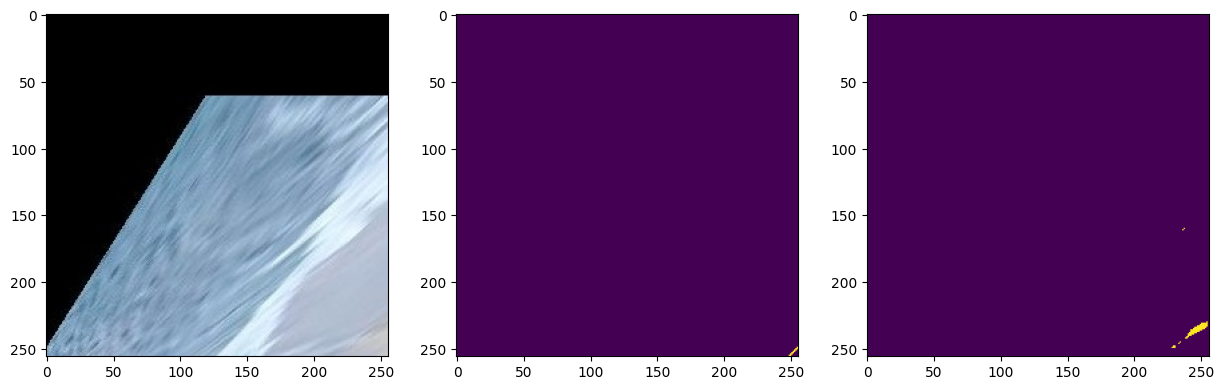

In [8]:
import numpy as np
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))
data = DataLoaderManager.load_data(os.path.abspath(os.path.join(os.getcwd(), "../../../data/patchify_shoreline/")))
index = 24
img_path = data["test"]['images'][index]
mask_path = data["test"]['masks'][index]

model = DuckNet(num_classes=1, experiment_name="test_experiments", use_mlflow=False)
model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-06-12-10-00-04_binary_ducknet/models/best_model.pth")))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

pred = model.predict(img_path, binary_threshold=0.1360)

print(np.unique(mask, return_counts=True))
print(np.unique(pred.cpu(), return_counts=True))


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred.cpu().squeeze())

plt.show()

In [12]:
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))

num_classes = 1
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False) # 'macro'
}

# Load the data to split it and save it to a dict
model = DuckNet(num_classes=1, experiment_name="test_experiments", use_mlflow=False)

model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-06-12-10-00-04_binary_ducknet/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_shoreline"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [4]:
for split in data:
    split = "test"
    print(f"Split: {split}")
    
    
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max", binary_threshold = 0.50)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())
    break

Split: test
test metrics: 
	test_accuracy: 0.8958243727684021
	test_f1_score: 0.03808318078517914
	test_precision: 0.019425397738814354
	test_recall: 0.963741660118103
	test_confusion_matrix: 
		0.8957 0.1043
		0.0363 0.9637



c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_shoreline\images\1607016000.Thu.Dec.03_18_20_00.CET.2020.cadiz.image.jpg


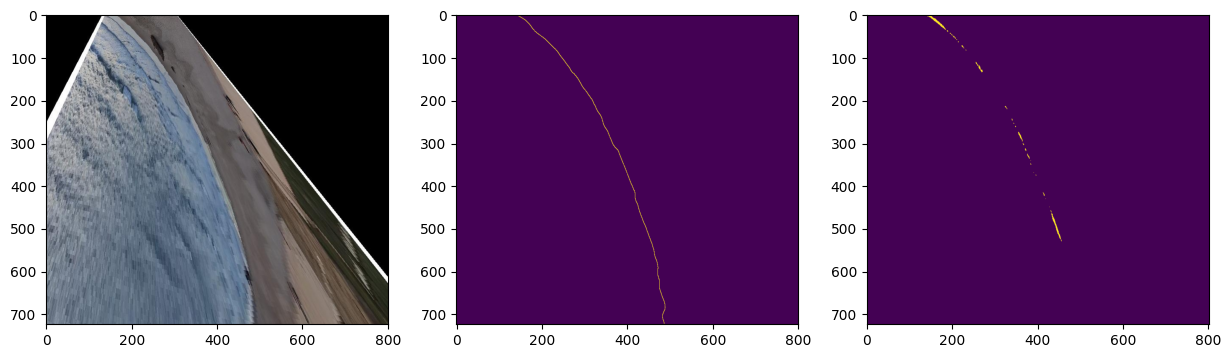

In [23]:
index = 50
img_path = sorted(data['test']['images'])[index] # 85
mask_path = sorted(data['test']['masks'])[index] # 85
print(img_path)

pred = model.predict_patch(img_path, combination="max", patch_size = 256, stride = 128, binary_threshold = 0.1360)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred.cpu().squeeze())

plt.show()

In [17]:
# Data with 4 classes, to be able to compute the shoreline distance

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_shoreline"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [26]:
# Create a folders system to save the results
# SCLabels_prediction_by_set_unet
#   - images
#       - train
#       - validation
#       - test
#   - masks
#       - train
#       - validation
#       - test
#   - predicted_mask
#       - train
#       - validation
#       - test

# Create the folders
subfolders = ["images", "masks", "predicted_mask"]
subset = ["train", "validation", "test"]

path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/SCLabels_prediction_by_set_duck-net_binary_0.1360/"))

os.makedirs(path, exist_ok=True)
for subfolder in subfolders:
    for s in subset:
        os.makedirs(os.path.join(path, subfolder, s), exist_ok=True)

In [27]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="avg", patch_size=256, stride=128, binary_threshold=0.1360)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the images
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        cv2.imwrite(os.path.join(path, "images", split, img_name), img)
        cv2.imwrite(os.path.join(path, "masks", split, mask_name), mask)
        cv2.imwrite(os.path.join(path, "predicted_mask", split, mask_name), pred.cpu().numpy())


Split: train
Split: validation
Split: test
